**Notation**:
- Superscript $[l]$ denotes an object of the $l^{th}$ layer. 
    - Example: $a^{[4]}$ is the $4^{th}$ layer activation. $W^{[5]}$ and $b^{[5]}$ are the $5^{th}$ layer parameters.


- Superscript $(i)$ denotes an object from the $i^{th}$ example. 
    - Example: $x^{(i)}$ is the $i^{th}$ training example input.
    
    
- Subscript $i$ denotes the $i^{th}$ entry of a vector.
    - Example: $a^{[l]}_i$ denotes the $i^{th}$ entry of the activations in layer $l$, assuming this is a fully connected (FC) layer.
    
    
- $n_H$, $n_W$ and $n_C$ denote respectively the height, width and number of channels of a given layer. If you want to reference a specific layer $l$, you can also write $n_H^{[l]}$, $n_W^{[l]}$, $n_C^{[l]}$. 
- $n_{H_{prev}}$, $n_{W_{prev}}$ and $n_{C_{prev}}$ denote respectively the height, width and number of channels of the previous layer. If referencing a specific layer $l$, this could also be denoted $n_H^{[l-1]}$, $n_W^{[l-1]}$, $n_C^{[l-1]}$. 

In [ ]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# 1) Forward Propagation of Conv Neural Network

## 1.1 Zero-Padding

Zero-padding adds zeros around the border of an image:

<img src="https://github.com/sebastianbirk/coursera-deep-learning-specialization/blob/master/04_convolutional_neural_networks/01_cnn_basics_with_numpy/images/PAD.png?raw=true" style="width:300px;height:200px;">
<caption><center> <u> Figure 1 </u>Zero-Padding<br> Image (3 channels, RGB) with a padding of 2. </center></caption>

The main benefits of padding are the following:

- It allows you to use a CONV layer without necessarily shrinking the height and width of the volumes. This is important for building deeper networks, since otherwise the height/width would shrink as you go to deeper layers. An important special case is the "same" convolution, in which the height/width is exactly preserved after one layer. 

- It helps us keep more of the information at the border of an image. Without padding, very few values at the next layer would be affected by pixels as the edges of an image.

In [ ]:
def zero_pad(X, pad):
    X_pad = np.pad(X, ((0, 0), (pad, pad), (pad, pad), (0, 0)), mode='constant', constant_values=(0,0))    
    return X_pad

x.shape =
 (4, 3, 3, 2)
x_pad.shape =
 (4, 7, 7, 2)


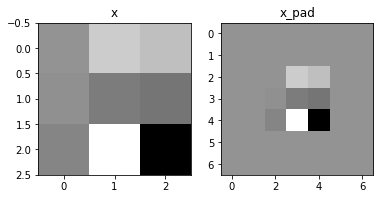

In [ ]:
x = np.random.randn(4, 3, 3, 2)
x_pad = zero_pad(x, 2)
print ("x.shape =\n", x.shape)
print ("x_pad.shape =\n", x_pad.shape)

fig, axarr = plt.subplots(1, 2);
axarr[0].set_title('x')
axarr[0].imshow(x[0,:,:,0])
axarr[1].set_title('x_pad')
axarr[1].imshow(x_pad[0,:,:,0])

## 1.2 Single step of convolution 


<img src="https://github.com/sebastianbirk/coursera-deep-learning-specialization/blob/master/04_convolutional_neural_networks/01_cnn_basics_with_numpy/images/Convolution_schematic.gif?raw=true" style="width:500px;height:300px;">
<caption><center> <u>Figure 2** </u>: Convolution operation<br> with a filter of 3x3 and a stride of 1 (stride = amount you move the window each time you slide) </center></caption>

In [ ]:
def conv_single_step(a_slice_prev, W, b):
    s = np.multiply(a_slice_prev, W)
    Z = np.sum(s)
    Z = Z + float(b)
    return Z

In [ ]:
a_slice_prev = np.random.randn(4, 4, 3)
W = np.random.randn(4, 4, 3)
b = np.random.randn(1, 1, 1)
Z = conv_single_step(a_slice_prev, W, b)
print("Z =", Z)

Z = 22.482037225685325


## 1.3 Convolutional Neural Networks - Forward pass

In the forward pass, you will take many filters and convolve them on the input. Each 'convolution' gives you a 2D matrix output. You will then stack these outputs to get a 3D volume: 

Notice how this gives a 3D slice that has height 2, width 2, and depth 3.  Depth is the number of channels. This will be useful when you will define `a_slice_prev` below, using the `start/end` indexes you will define. To define a_slice you will need to first define its corners `vert_start`, `vert_end`, `horiz_start` and `horiz_end`. This figure may be helpful for you to find out how each of the corner can be defined using h, w, f and s in the code below.

<img src="https://github.com/sebastianbirk/coursera-deep-learning-specialization/blob/master/04_convolutional_neural_networks/01_cnn_basics_with_numpy/images/vert_horiz_kiank.png?raw=true" style="width:400px;height:300px;">
<caption><center> <u> Figure 3 </u>: **Definition of a slice using vertical and horizontal start/end (with a 2x2 filter)** <br> This figure shows only a single channel.  </center></caption>

The formulas relating the output shape of the convolution to the input shape is:
$$ n_H = \lfloor \frac{n_{H_{prev}} - f + 2 \times pad}{stride} \rfloor +1 $$
$$ n_W = \lfloor \frac{n_{W_{prev}} - f + 2 \times pad}{stride} \rfloor +1 $$
$$ n_C = \text{number of filters used in the convolution}$$

In [ ]:
def conv_forward(A_prev, W, b, hparameters):

    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape[0], A_prev.shape[1], A_prev.shape[2], A_prev.shape[3]
    (f, f, n_C_prev, n_C) = W.shape[0], W.shape[1], W.shape[2], W.shape[3]
    
    # Retrieve information from "hparameters"
    stride = hparameters["stride"]
    pad = hparameters["pad"]
    
    # Compute the dimensions of the CONV output volume
    n_H = int(int(n_H_prev + 2 * pad - f) / stride + 1)
    n_W = int(int(n_W_prev + 2 * pad - f) / stride + 1)
    
    # Initialize the output volume Z with zeros.
    Z = np.zeros([m, n_H, n_W, n_C])
    
    # Create A_prev_pad by padding A_prev
    A_prev_pad = zero_pad(A_prev, pad)
    
    for i in range(m):                 
        a_prev_pad = A_prev_pad[i] 
        for h in range(n_H):         
            # Find the vertical start and end of the current "slice"
            vert_start = stride * h
            vert_end = vert_start + f
            
            # loop over horizontal axis of the output volume
            for w in range(n_W):       
                horiz_start = stride * w
                horiz_end = horiz_start + f
                
                # loop over channels
                for c in range(n_C): 
                                        
                    # Use the corners to define the (3D) slice of a_prev_pad
                    a_slice_prev = A_prev_pad[i, vert_start:vert_end, horiz_start:horiz_end, :]
                    
                    # Convolve the (3D) slice with the correct filter W and bias b, to get back one output neuron.
                    weights = W[:, :, :, c]
                    biases = b[:, :, :, c]
                    Z[i, h, w, c] = conv_single_step(a_slice_prev, weights, biases) # (m, n_H, n_W, n_C)
                                        
    # Save information in "cache" for the backprop
    cache = (A_prev, W, b, hparameters)
    return Z, cache

In [ ]:
Z.shape

(10, 3, 4, 8)

In [ ]:
A_prev = np.random.randn(10, 5, 7, 4)
W = np.random.randn(3,3,4,8)
b = np.random.randn(1,1,1,8)
hparameters = {"pad" : 1, "stride": 2}
Z, cache_conv = conv_forward(A_prev, W, b, hparameters)
print("Z's mean =\n", np.mean(Z))
print("Z[3,2,1] =\n", Z[3,2,1])

Z's mean =
 0.0620556310862257
Z[3,2,1] =
 [ 6.43363127 -1.19132156 -2.30354316  6.68092325 -3.07408661  5.86504131
 -4.53299535 -9.2187148 ]


## 1.4 Pooling layer 

The pooling (POOL) layer reduces the height and width of the input. It helps reduce computation, as well as helps make feature detectors more invariant to its position in the input. The two types of pooling layers are: 

- Max-pooling layer: slides an ($f, f$) window over the input and stores the max value of the window in the output.

- Average-pooling layer: slides an ($f, f$) window over the input and stores the average value of the window in the output.

<table>
<td>
<img src="https://github.com/sebastianbirk/coursera-deep-learning-specialization/blob/master/04_convolutional_neural_networks/01_cnn_basics_with_numpy/images/ave_pool1.png?raw=true" style="width:500px;height:300px;">
<td>

<td>
<img src="https://github.com/sebastianbirk/coursera-deep-learning-specialization/blob/master/04_convolutional_neural_networks/01_cnn_basics_with_numpy/images/max_pool1.png?raw=true" style="width:500px;height:300px;">
<td>
</table>

These pooling layers have no parameters for backpropagation to train. However, they have hyperparameters such as the window size $f$. This specifies the height and width of the $f \times f$ window you would compute a *max* or *average* over. 

## 1.5 Forward Pooling
Now, you are going to implement MAX-POOL and AVG-POOL, in the same function. 

**Exercise**: Implement the forward pass of the pooling layer. Follow the hints in the comments below.

**Reminder**:
As there's no padding, the formulas binding the output shape of the pooling to the input shape is:

$$ n_H = \lfloor \frac{n_{H_{prev}} - f}{stride} \rfloor +1 $$

$$ n_W = \lfloor \frac{n_{W_{prev}} - f}{stride} \rfloor +1 $$

$$ n_C = n_{C_{prev}}$$

In [ ]:
def pool_forward(A_prev, hparameters, mode = "max"):    
    # Retrieve dimensions from the input shape
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Retrieve hyperparameters from "hparameters"
    f = hparameters["f"]
    stride = hparameters["stride"]
    
    # Define the dimensions of the output
    n_H = int(1 + (n_H_prev - f) / stride)
    n_W = int(1 + (n_W_prev - f) / stride)
    n_C = n_C_prev
    
    # Initialize output matrix A
    A = np.zeros((m, n_H, n_W, n_C))              
    
    # loop over the training examples
    for i in range(m): 

        for h in range(n_H):                     
            vert_start = stride * h 
            vert_end = vert_start + f
            
            for w in range(n_W):                
                horiz_start = stride * w
                horiz_end = horiz_start + f
                
                for c in range (n_C):         
                    a_prev_slice = A_prev[i]
                    
                    if mode == "max":
                        A[i, h, w, c] = np.max(a_prev_slice[vert_start:vert_end, horiz_start:horiz_end, c])
                    elif mode == "average":
                        A[i, h, w, c] = np.mean(a_prev_slice[vert_start:vert_end, horiz_start:horiz_end, c])
        
    # Store the input and hparameters in "cache" for pool_backward()
    cache = (A_prev, hparameters)
    return A, cache

In [ ]:
# unit test: stride of 2
np.random.seed(1)
A_prev = np.random.randn(2, 5, 5, 3)
hparameters = {"stride" : 2, "f": 3}

A, cache = pool_forward(A_prev, hparameters)
print("mode = max")
print("A.shape = " + str(A.shape))
print()

A, cache = pool_forward(A_prev, hparameters, mode = "average")
print("mode = average")
print("A.shape = " + str(A.shape))

mode = max
A.shape = (2, 2, 2, 3)

mode = average
A.shape = (2, 2, 2, 3)


# 2) Backpropagation

## 2.1 Backpropagation in Convolutional Layers

In modern deep learning frameworks, you only have to implement the forward pass, and the framework takes care of the backward pass, so most deep learning engineers don't need to bother with the details of the backward pass. The backward pass for convolutional networks is complicated. 

**Computing dA:**
This is the formula for computing $dA$ with respect to the cost for a certain filter $W_c$ and a given training example:

$$ dA += \sum _{h=0} ^{n_H} \sum_{w=0} ^{n_W} W_c \times dZ_{hw} \tag{1}$$

Where $W_c$ is a filter and $dZ_{hw}$ is a scalar corresponding to the gradient of the cost with respect to the output of the conv layer Z at the hth row and wth column (corresponding to the dot product taken at the ith stride left and jth stride down). Note that at each time, we multiply the the same filter $W_c$ by a different dZ when updating dA. We do so mainly because when computing the forward propagation, each filter is dotted and summed by a different a_slice. Therefore when computing the backprop for dA, we are just adding the gradients of all the a_slices. 

**Computing dW:**
This is the formula for computing $dW_c$ ($dW_c$ is the derivative of one filter) with respect to the loss:

$$ dW_c  += \sum _{h=0} ^{n_H} \sum_{w=0} ^ {n_W} a_{slice} \times dZ_{hw}  \tag{2}$$

Where $a_{slice}$ corresponds to the slice which was used to generate the activation $Z_{ij}$. Hence, this ends up giving us the gradient for $W$ with respect to that slice. Since it is the same $W$, we will just add up all such gradients to get $dW$. 

**Computing db:**
This is the formula for computing $db$ with respect to the cost for a certain filter $W_c$:

$$ db = \sum_h \sum_w dZ_{hw} \tag{3}$$

As you have previously seen in basic neural networks, db is computed by summing $dZ$. In this case, you are just summing over all the gradients of the conv output (Z) with respect to the cost. 

In [ ]:
def conv_backward(dZ, cache):
    """
    Implement the backward propagation for a convolution function
    """
    
    (A_prev, W, b, hparameters) = cache
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    (f, f, n_C_prev, n_C) = W.shape
    
    stride = hparameters["stride"]
    pad = hparameters["pad"]
    
    (m, n_H, n_W, n_C) = dZ.shape
    
    # Initialize dA_prev, dW, db with the correct shapes
    dA_prev = np.zeros(((m, n_H_prev, n_W_prev, n_C_prev)))                           
    dW = np.zeros((f, f, n_C_prev, n_C))
    db = np.zeros((1, 1, 1, n_C))

    # Pad A_prev and dA_prev
    A_prev_pad = zero_pad(A_prev, pad)
    dA_prev_pad = zero_pad(dA_prev, pad)
    
    for i in range(m):                       
        a_prev_pad = A_prev_pad[i]
        da_prev_pad = dA_prev_pad[i]
        
        for h in range(n_H):                   
            for w in range(n_W):               
                for c in range(n_C):          
                    vert_start = h * stride
                    vert_end = h * stride + f
                    horiz_start = w * stride 
                    horiz_end = w * stride + f
                    
                    a_slice = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]
                    da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :] += W[:,:,:,c] * dZ[i, h, w, c]
                    dW[:,:,:,c] += a_slice * dZ[i, h, w, c]
                    db[:,:,:,c] += dZ[i, h, w, c]
                    
        dA_prev[i, :, :, :] = da_prev_pad[pad:-pad, pad:-pad, :]
    
    return dA_prev, dW, db

In [ ]:
A_prev = np.random.randn(10,4,4,3)
W = np.random.randn(2,2,3,8)
b = np.random.randn(1,1,1,8)
hparameters = {"pad" : 2,
               "stride": 2}
Z, cache_conv = conv_forward(A_prev, W, b, hparameters)

# Test conv_backward
dA, dW, db = conv_backward(Z, cache_conv)
print("dA_mean =", np.mean(dA))
print("dW_mean =", np.mean(dW))
print("db_mean =", np.mean(db))

dA_mean = 0.15859612863102365
dW_mean = 2.312038300087775
db_mean = 106.15232357611558


## 2.2 Max Pooling layer - backward pass

Even though a pooling layer has no parameters for backprop to update, you still need to backpropagation the gradient through the pooling layer in order to compute gradients for layers that came before the pooling layer. 

In [ ]:
def create_mask_from_window(x):
    """
    Creates a mask from an input matrix x, to identify the max entry of x.
    Arguments:
    x -- Array of shape (f, f)
    Returns:
    mask -- Array of the same shape as window, contains a True at the position corresponding to the max entry of x.
    """    
    mask = (x == np.max(x))    
    return mask

In [ ]:
np.random.seed(1)
x = np.random.randn(2,3)
mask = create_mask_from_window(x)
print('x = ', x)
print("mask = ", mask)

x =  [[ 1.62434536 -0.61175641 -0.52817175]
 [-1.07296862  0.86540763 -2.3015387 ]]
mask =  [[ True False False]
 [False False False]]


Why do we keep track of the position of the max? It's because this is the input value that ultimately influenced the output, and therefore the cost. Backprop is computing gradients with respect to the cost, so anything that influences the ultimate cost should have a non-zero gradient. So, backprop will "propagate" the gradient back to this particular input value that had influenced the cost. 

## 2.3 Average pooling - backward pass 

In max pooling, for each input window, all the "influence" on the output came from a single input value--the max. In average pooling, every element of the input window has equal influence on the output. So to implement backprop, you will now implement a helper function that reflects this.

For example if we did average pooling in the forward pass using a 2x2 filter, then the mask you'll use for the backward pass will look like: 
$$ dZ = 1 \quad \rightarrow  \quad dZ =\begin{bmatrix}
1/4 && 1/4 \\
1/4 && 1/4
\end{bmatrix}\tag{5}$$

This implies that each position in the $dZ$ matrix contributes equally to output because in the forward pass, we took an average. 

In [ ]:
def distribute_value(dz, shape):
    """
    Distributes the input value in the matrix of dimension shape
    
    Arguments:
    dz -- input scalar
    shape -- the shape (n_H, n_W) of the output matrix for which we want to distribute the value of dz
    
    Returns:
    a -- Array of size (n_H, n_W) for which we distributed the value of dz
    """
    # Retrieve dimensions from shape
    (n_H, n_W) = shape
    
    # Compute the value to distribute on the matrix
    average = dz/(n_H * n_W)
    
    # Create a matrix where every entry is the "average" value
    a = np.ones((shape)) * average
    
    return a

In [ ]:
a = distribute_value(2, (2,2))
print('distributed value =', a)

distributed value = [[0.5 0.5]
 [0.5 0.5]]


##  2.4 Putting it together: Pooling backward 

In [ ]:
def pool_backward(dA, cache, mode = "max"):
    """
    Implements the backward pass of the pooling layer
    
    Arguments:
    dA -- gradient of cost with respect to the output of the pooling layer, same shape as A
    cache -- cache output from the forward pass of the pooling layer, contains the layer's input and hparameters 
    mode -- the pooling mode you would like to use, defined as a string ("max" or "average")
    
    Returns:
    dA_prev -- gradient of cost with respect to the input of the pooling layer, same shape as A_prev
    """
        
    (A_prev, hparameters) = cache
    stride = hparameters["stride"]
    f = hparameters["f"]
    
    m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape
    m, n_H, n_W, n_C = dA.shape
    
    # Initialize dA_prev with zeros 
    dA_prev = np.zeros((m, n_H_prev, n_W_prev, n_C_prev))
    
    for i in range(m):                      
        a_prev = A_prev[i]
        
        for h in range(n_H):                   
            for w in range(n_W):              
                for c in range(n_C):        
                    
                    # Find the corners of the current "slice"
                    vert_start = h * stride
                    vert_end = h * stride + f
                    horiz_start = w * stride
                    horiz_end = w * stride + f
                    
                    # Compute the backward propagation in both modes.
                    if mode == "max":
                        # Use the corners and "c" to define the current slice from a_prev
                        a_prev_slice = a_prev[vert_start:vert_end, horiz_start:horiz_end, c]
                        # Create the mask from a_prev_slice
                        mask = create_mask_from_window(a_prev_slice)
                        # Set dA_prev to be dA_prev + (the mask multiplied by the correct entry of dA)
                        dA_prev[i, vert_start: vert_end, horiz_start: horiz_end, c] += mask * dA[i, h, w, c]
                        
                    elif mode == "average":
                        
                        # Get the value a from dA
                        da = dA[i, h, w, c]
                        # Define the shape of the filter as fxf
                        shape = (f, f)
                        # Distribute it to get the correct slice of dA_prev. i.e. Add the distributed value of da.
                        dA_prev[i, vert_start: vert_end, horiz_start: horiz_end, c] += distribute_value(da, shape)
                              
    return dA_prev

In [ ]:
np.random.seed(1)
A_prev = np.random.randn(5, 5, 3, 2)
hparameters = {"stride" : 1, "f": 2}
A, cache = pool_forward(A_prev, hparameters)
dA = np.random.randn(5, 4, 2, 2)

dA_prev = pool_backward(dA, cache, mode = "max")
print("mode = max")
print('mean of dA = ', np.mean(dA))
print('dA_prev[1,1] = ', dA_prev[1,1])  
print()
dA_prev = pool_backward(dA, cache, mode = "average")
print("mode = average")
print('mean of dA = ', np.mean(dA))
print('dA_prev[1,1] = ', dA_prev[1,1]) 

mode = max
mean of dA =  0.14571390272918056
dA_prev[1,1] =  [[ 0.          0.        ]
 [ 5.05844394 -1.68282702]
 [ 0.          0.        ]]

mode = average
mean of dA =  0.14571390272918056
dA_prev[1,1] =  [[ 0.08485462  0.2787552 ]
 [ 1.26461098 -0.25749373]
 [ 1.17975636 -0.53624893]]
